Eksperyment 1 ma na celu zbadanie zgodności (i stabilności) macierzy sąsiedztwa uzyskanych:

- z parametrów modelu
- z próbki z modelu

przy zastosowaniu różnych technik dyskretyzacji.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex
import json
import urllib
import datetime
from tqdm import tqdm
import itertools
from scipy.stats import multivariate_normal

from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from pathlib import Path
from hmmlearn import hmm
import sys
PROJECT_PATH = f"/ziob/klaudia/FlowHMM"
sys.path.insert(1, PROJECT_PATH)
from torchHMM.utils.utils import  total_variance_dist
from torchHMM.model.discretized_HMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES, HmmOptim
LEARNING_ALGORITHMS = ["em", "cooc"]

In [2]:
sns.set_style("white")

with urllib.request.urlopen('https://xkcd.com/color/rgb.txt') as f:
    colors = f.readlines()
color_names = [str(c)[2:].split('\\t')[0] for c in colors[1:]]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
np.random.seed(2023)

In [4]:
true_model = hmm.GaussianHMM(n_components=3, covariance_type="full")

# true_model.startprob_ = np.array([0.6, 0.3, 0.1])
# true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
#                             [0.3, 0.5, 0.2],
#                             [0.3, 0.3, 0.4]])
#
# true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
# true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]])

true_model.startprob_ = np.array([0.6, 0.3, 0.1])
true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]]) * .8

In [5]:
X_train, Z_train = true_model.sample(100000)
X_test, Z_test = true_model.sample(1000)

In [6]:
norm1 = multivariate_normal(true_model.means_[0], true_model.covars_[0])
norm2 = multivariate_normal(true_model.means_[1], true_model.covars_[1])
norm3 = multivariate_normal(true_model.means_[2], true_model.covars_[2])
norms = [norm1, norm2, norm3]

Wybór metryk i sposób prezentacji:

1. Dla 25, 100, 400 węzłów:
    - wykres: rozkłady ze stanów a węzły
    - wykres: zgodność macierzy sąsiedztwa
    - powtórz 100 razy:
        - KL: zgodność macierzy sąsiedztwa
        - d_{tv}: zgodność macierzy sąsiedztwa
    - wykres: metryki z przedziałami ufności

In [9]:
def plot_Q_from_model(model_):
    S_ = model_.transmat_ * model_.startprob_[:, np.newaxis]
    distributions_ = [
            scipy.stats.multivariate_normal(model_.means_[i], model_.covars_[i])
            for i in range(model_.n_components)
        ]

    B_ = np.concatenate(
            [
                dist.pdf(model_.nodes.T).reshape(
                    1, -1
                )
                for dist in distributions_
            ],
            axis=0,
        )
    B_ = B_ / B_.sum(1)[:, np.newaxis]
    return B_.T @ S_ @ B_


def init_model(discretize_meth):
    model = DiscreteHMM(discretize_meth, n, n_components=3, learning_alg='cooc', verbose=True, params="", init_params="",
                        optim_params=dict(max_epoch=50000, lr=0.1, weight_decay=0), n_iter=100)

    model.startprob_ = true_model.startprob_
    model.transmat_ = true_model.transmat_
    model.means_ = true_model.means_
    model.covars_ = true_model.covars_
    return model


def plot_true_HMM(X, model, path=None):

    x1, y1 = X.min(axis=0) * 1.1
    x2, y2 = X.max(axis=0) * 1.1

    XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
    data = np.column_stack((XX.ravel(), YY.ravel()))
    lls = np.concatenate([norm.pdf(data).reshape(-1, 1) for norm in norms], axis=1)

    plt.figure(figsize=(5, 5))
    for k in range(model.n_components):
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=8)

    plt.scatter(model.nodes[0], model.nodes[1])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions")
    if path is not None:
        plt.savefig(path)
    plt.show()

def kl_divergence(p_, q_):
    p = p_.reshape(-1)
    q = q_.reshape(-1)
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)) if q[i] > 0)



## random

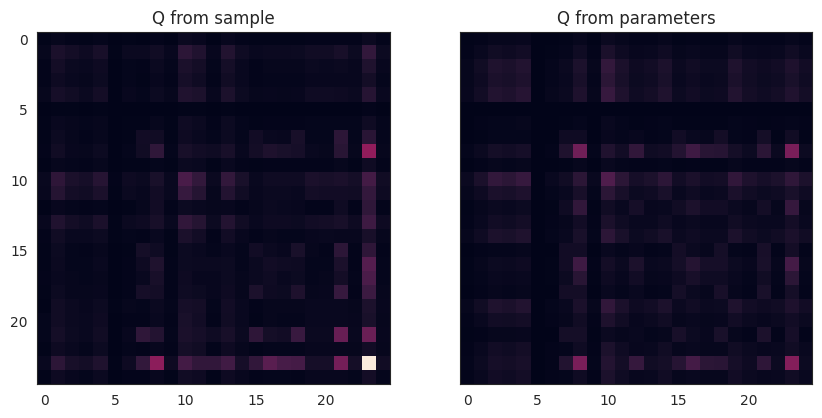

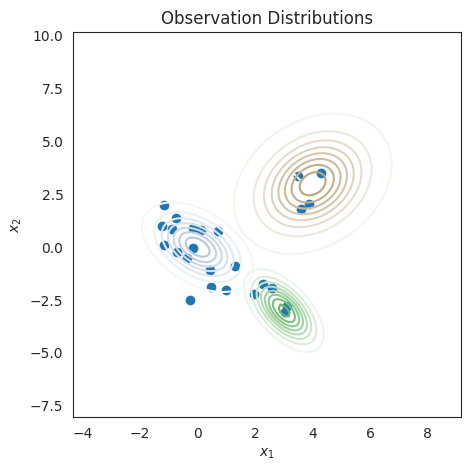

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4/5 [00:33<00:08,  8.41s/it]/tmp/ipykernel_2763748/1047186178.py:56: RuntimeWarning: divide by zero encountered in log2
  return sum(p[i] * np.log2(p[i]/q[i] if q[i] != 0 else 1) for i in range(len(p)))
/tmp/ipykernel_2763748/1047186178.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return sum(p[i] * np.log2(p[i]/q[i] if q[i] != 0 else 1) for i in range(len(p)))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.42s/it]


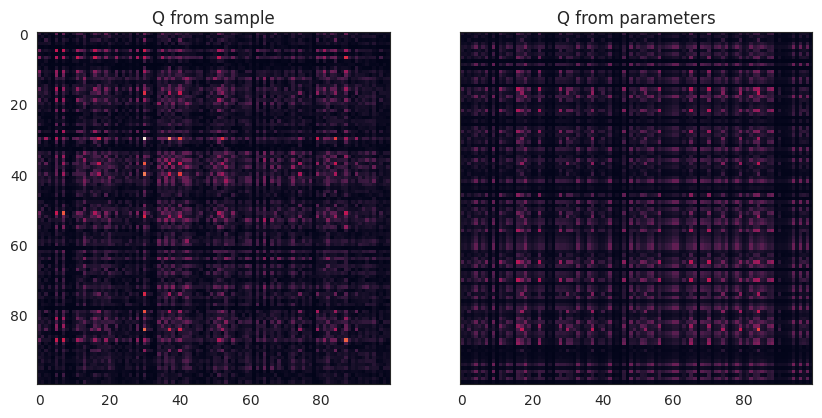

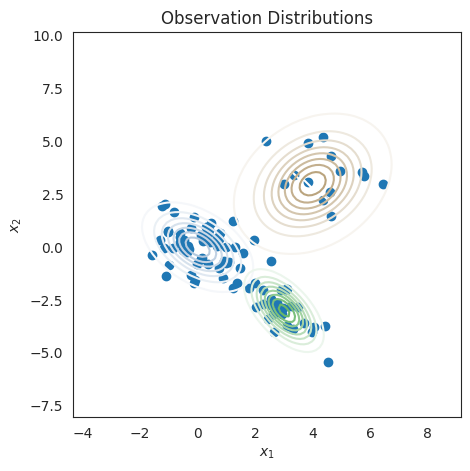

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.81s/it]


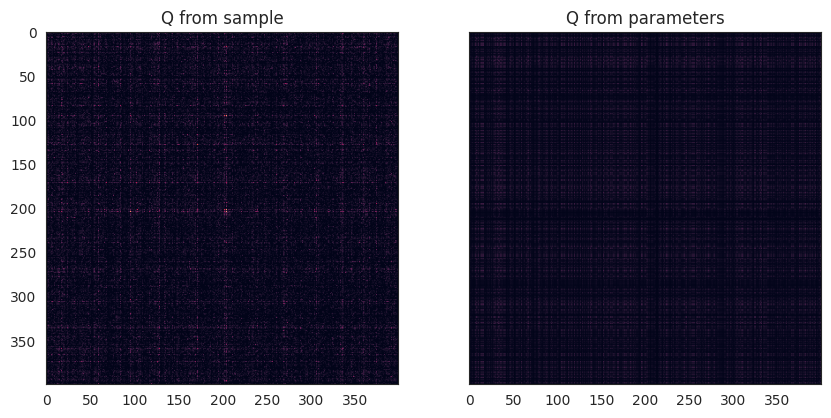

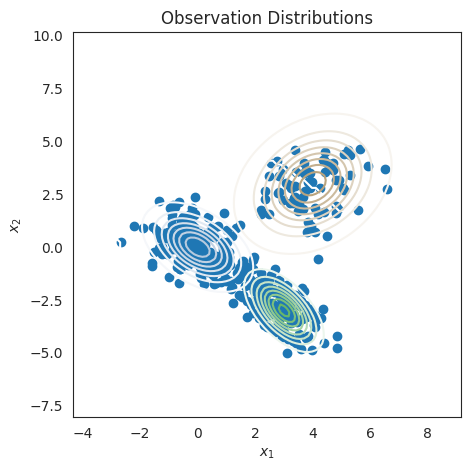

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.56s/it]




## latin_cube_u

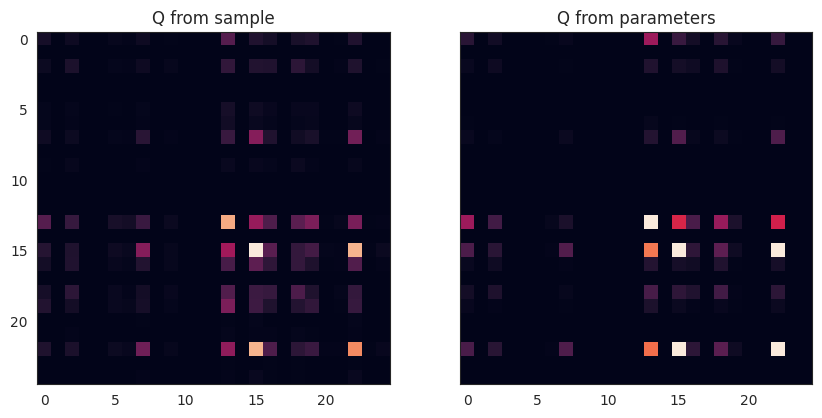

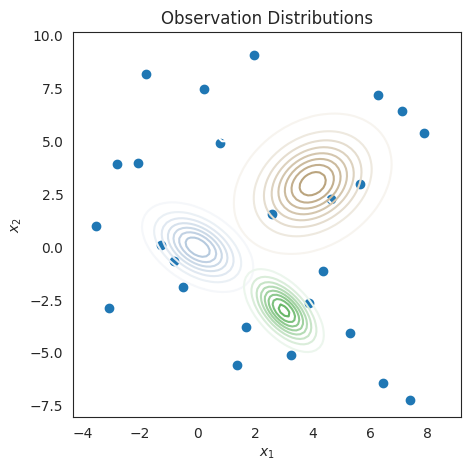

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.46s/it]


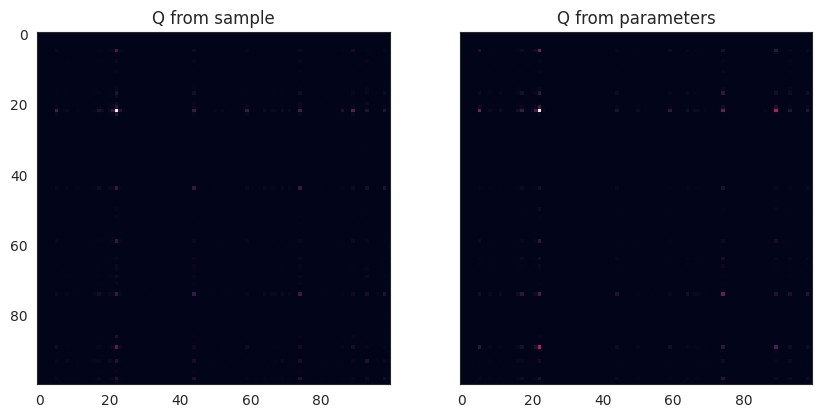

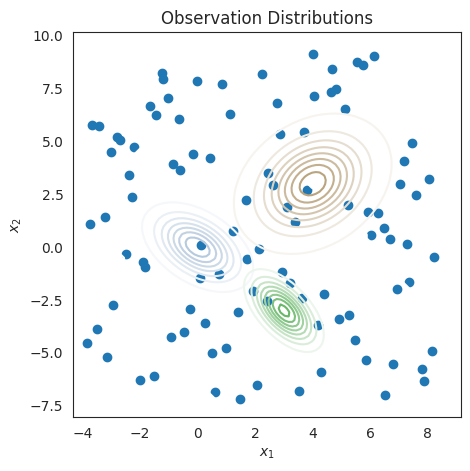

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.66s/it]


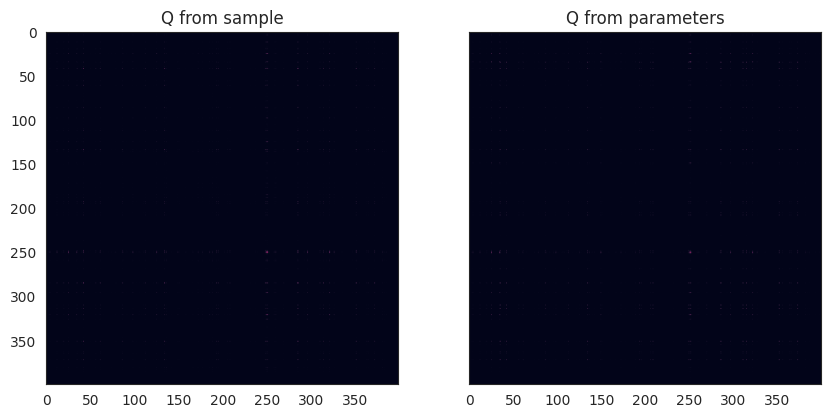

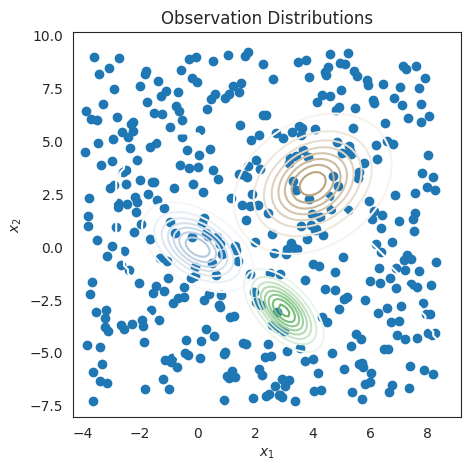

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.62s/it]




## latin_cube_q

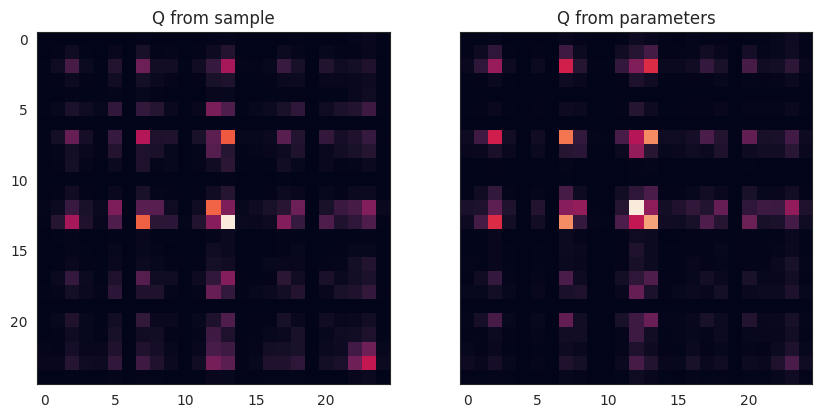

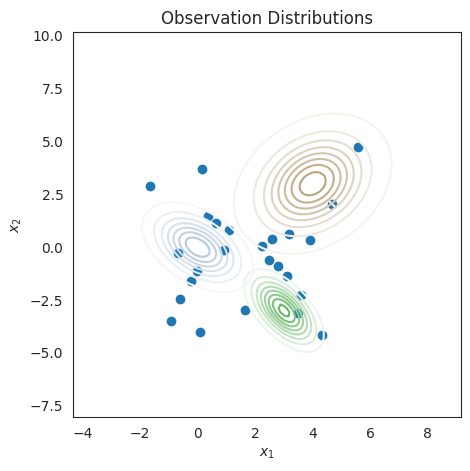

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.40s/it]


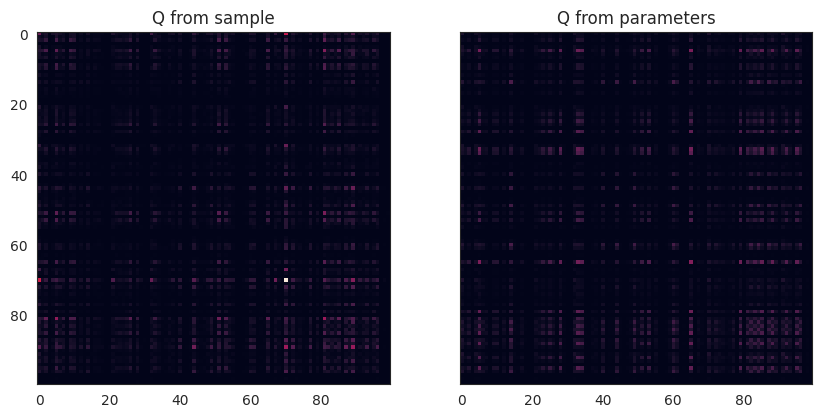

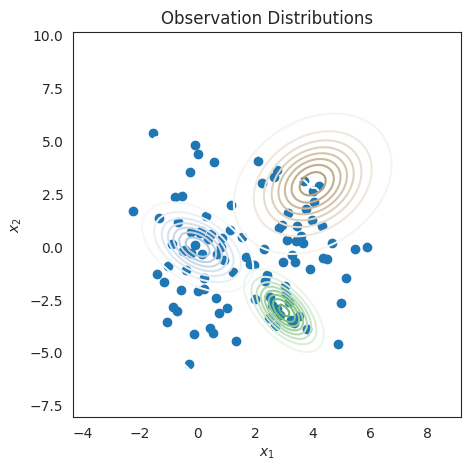

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


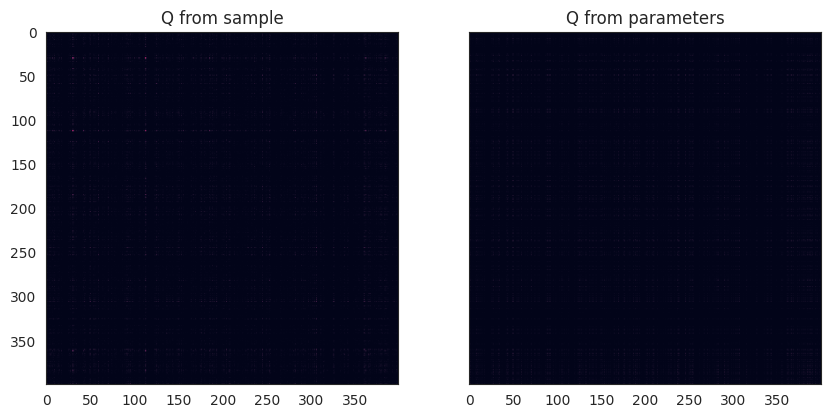

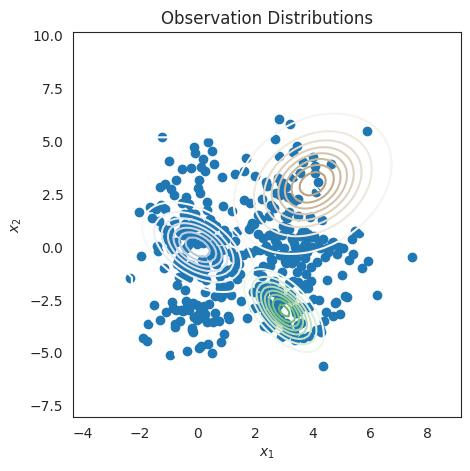

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.70s/it]




## uniform

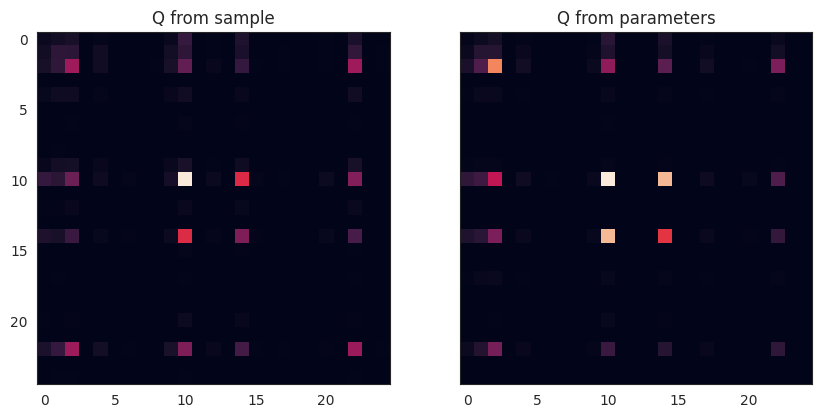

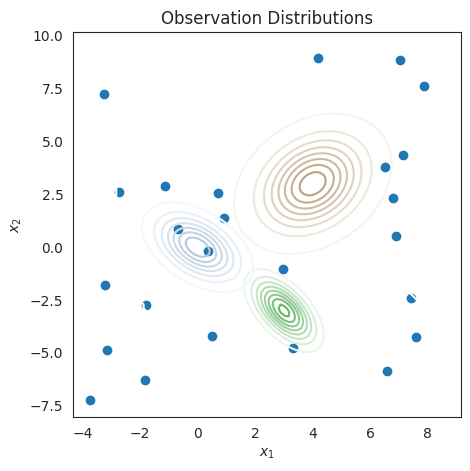

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


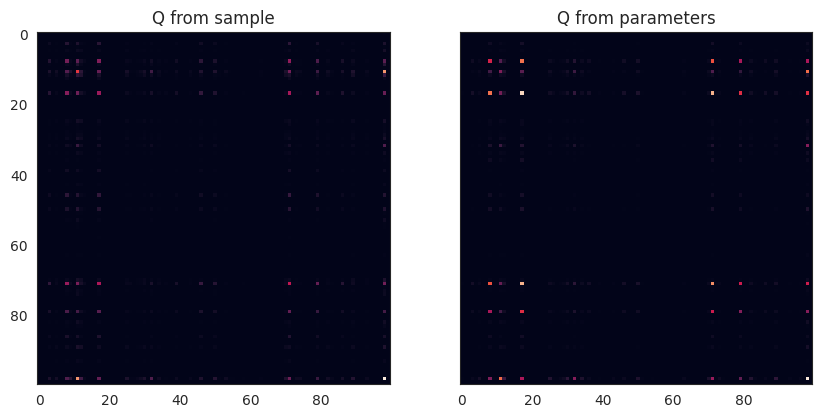

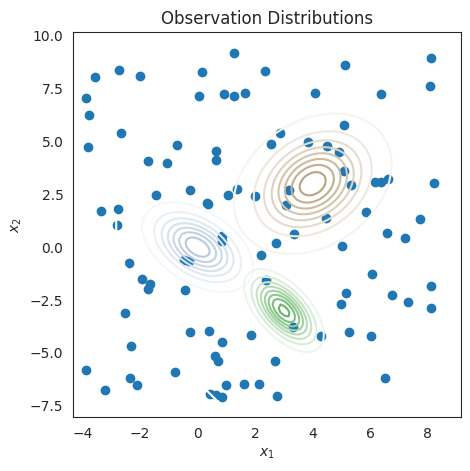

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.86s/it]


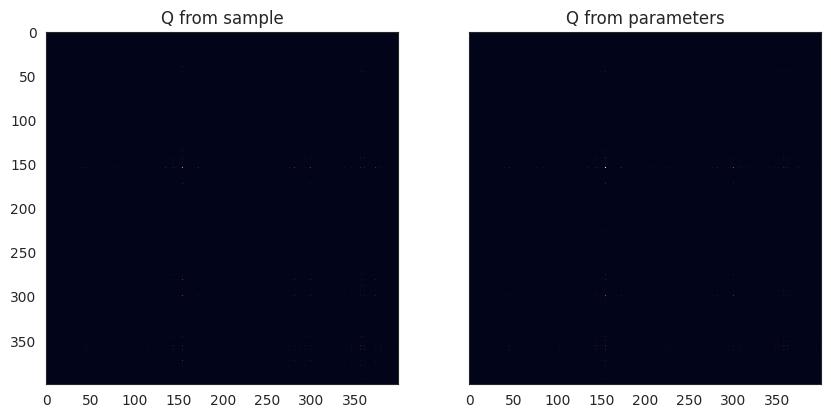

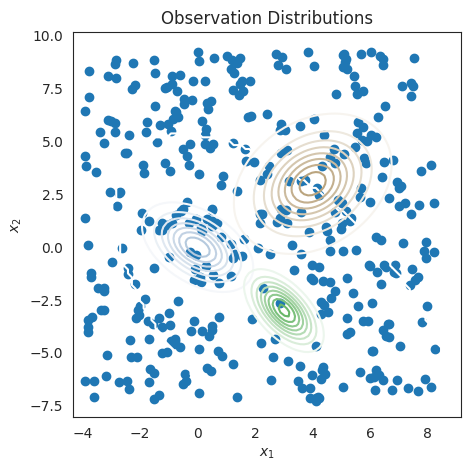

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.67s/it]




## grid

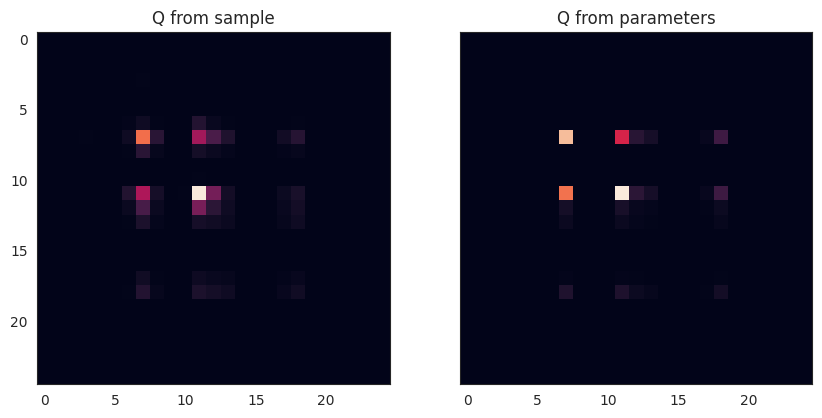

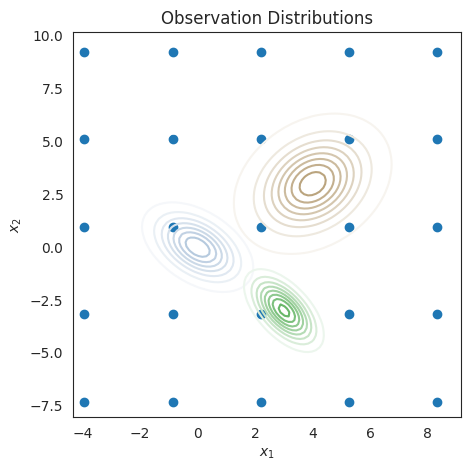

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.39s/it]


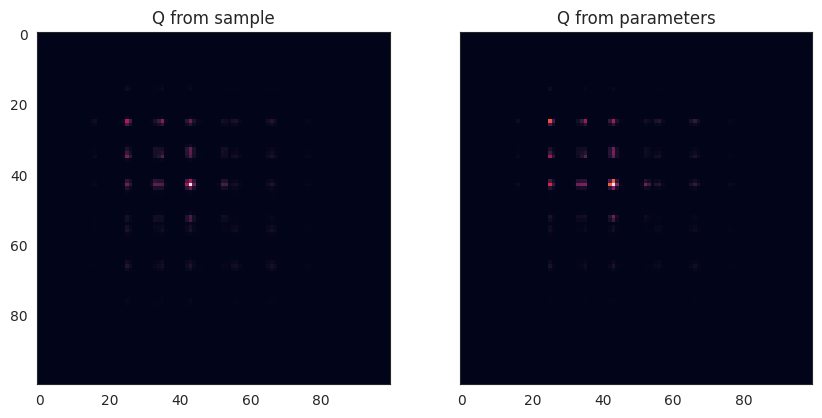

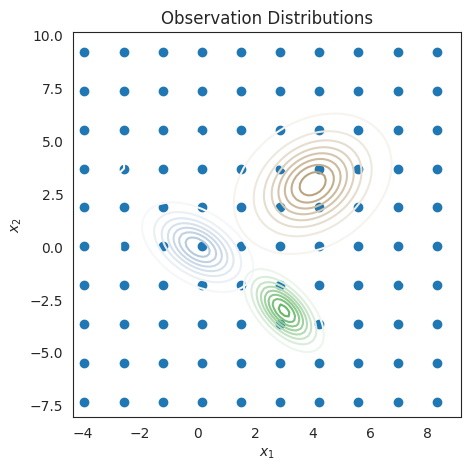

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.83s/it]


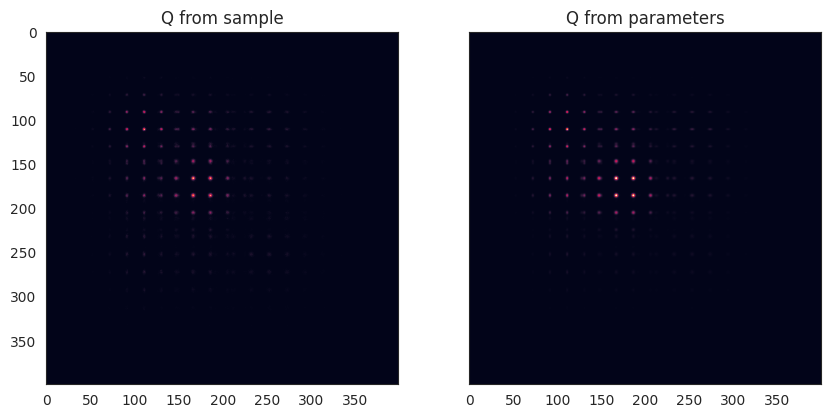

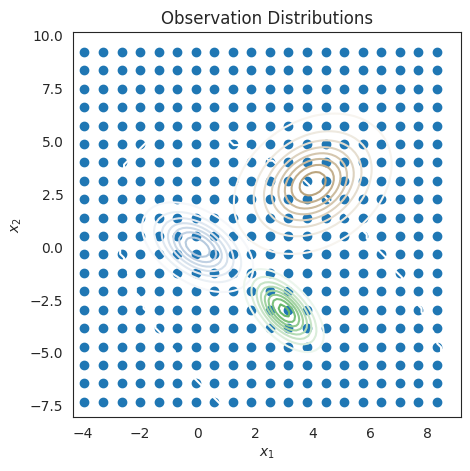

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.51s/it]


In [10]:
results = list()
Path(f"{PROJECT_PATH}/theoretical_experiment/plots").mkdir(exist_ok=True, parents=True)
for discretize_meth in DISCRETIZATION_TECHNIQUES:
    display(Markdown(f"\n\n## {discretize_meth}"))
    for n in [10, 25, 50, 100, 400]:
        fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(10, 10))
        model = init_model(discretize_meth)
        model._init(X_train)
        Xd = model.discretize(X_train, True)

        Q_cooc = model._cooccurence(Xd)
        vmin, vmax = Q_cooc.min(), Q_cooc.max()
        ax0.imshow(Q_cooc, vmin=vmin, vmax=vmax)
        ax0.set_title("Q from sample")
        Q_true_model = plot_Q_from_model(model)
        ax1.imshow(Q_true_model, vmin=vmin, vmax=vmax)
        ax1.set_title("Q from parameters")
        plt.savefig(f"{PROJECT_PATH}/theoretical_experiment/plots/1_Q_{discretize_meth}_{n}.png")
        plt.show()

        plot_true_HMM(X_train, model, f"{PROJECT_PATH}/theoretical_experiment/plots/1_nodes_{discretize_meth}_{n}.png")

        for _ in tqdm(range(100)):
            X, Z = true_model.sample(100000)
            model = init_model(discretize_meth)
            model._init(X)
            Xd = model.discretize(X, True)

            Q_cooc = model._cooccurence(Xd)
            Q_true_model = plot_Q_from_model(model)

            kl = kl_divergence(Q_cooc, Q_true_model)
            dtv = total_variance_dist(Q_cooc, Q_true_model)
            results.append({'KL': kl, 'd_tv': dtv, 'disc': discretize_meth, 'n': n})

with open(f"{PROJECT_PATH}/theoretical_experiment/1_discretization_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')}.json", 'w') as f:
    json.dump(results, f)

In [11]:
results = pd.DataFrame(results)

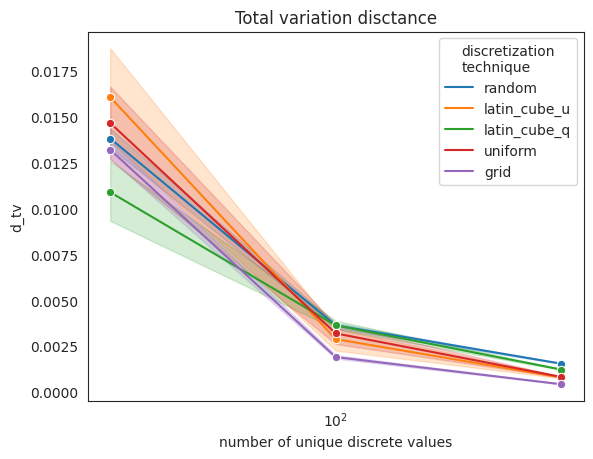

In [24]:
sns.lineplot(results, x='n', y='d_tv', hue='disc', marker='o')
plt.title("Total variation disctance")
plt.xlabel('number of unique discrete values')
plt.legend(title="discretization\ntechnique")
plt.xscale('log')
plt.savefig(f"{PROJECT_PATH}/theoretical_experiment/plots/1_dtv.png")
plt.show()

In [ ]:
sns.lineplot(results, x='n', y='KL', hue='disc', marker='o')
plt.title("Kulback Leibler divergence")
plt.xlabel('number of unique discrete values')
plt.legend(title="discretization\ntechnique")
plt.xscale('log')
plt.savefig(f"{PROJECT_PATH}/theoretical_experiment/plots/1_KL.png")
plt.show()